In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
sns.set_context("talk")
plt.style.use('dark_background')

df_wine = pd.read_csv('./wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ashs',
                  'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
                  'Proanthcyanins', 'Color itensity', 'Hue', 'OD280/OD315 of diluted wines',
                  'Proline']
X = df_wine.loc[: , df_wine.columns != 'Class label']
y = df_wine.loc[:,'Class label']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.fit_transform(X_test)

### step 1: クラス内変動行列を求める

In [38]:
### データセット全てに対して、クラスごとの特徴点の平均値を計算
np.set_printoptions(precision=4)
y_range = np.sort(y_train.unique())
mean_vecs = []
for i in y_range:
    mean_vecs.append(np.mean(X_train_std[y_train==i], axis=0))
    print('MV %s: %s' %(i, mean_vecs[i-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]
MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]
MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]


In [58]:
d = X_train_std.shape[1]
S_W2 = np.zeros((d,d))
for label, mv in zip(y_range, mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W2 += class_scatter

In [86]:
d = X_train_std.shape[1]
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d,1)
S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

In [87]:
mat = np.linalg.inv(S_W2).dot(S_B)
eigen_val, eigen_vec = np.linalg.eig(mat)

In [88]:
eigen_pair = [(np.abs(eigen_val[i]), eigen_vec[:,i]) for i in range(len(eigen_val))]
eigen_pair.sort(key=lambda k: k[0], reverse=True)

### 分散説明率

In [96]:
total = sum(eigen_val.real)
explained_ratio = [(i / total) for i in sorted(eigen_val.real, reverse=True)]
explained_ratio_cum = np.cumsum(explained_ratio)

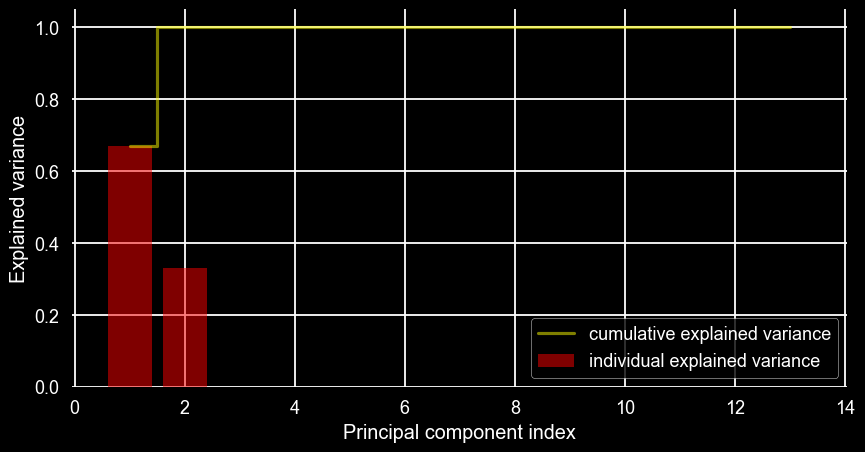

In [98]:
fig = plt.figure(figsize=(10,5),dpi=100)
plt.bar(range(1,14), explained_ratio, alpha=0.5, color='red', align = 'center', label='individual explained variance')
plt.step(range(1,14), explained_ratio_cum, alpha=0.5, color='yellow', where='mid', label = 'cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal component index')
plt.legend(loc='best', frameon=True, edgecolor="white")

In [101]:
w = np.hstack((eigen_pair[0][1][:,np.newaxis].real, eigen_pair[1][1][:,np.newaxis].real))

In [103]:
X_train_LDA = X_train_std.dot(w)

In [106]:
df = pd.DataFrame(X_train_LDA, columns=['LDA1', 'LDA2'])
df['Class'] = pd.DataFrame(np.array(y_train),index=None)
df['LDA2'] = df['LDA2']*(-1)

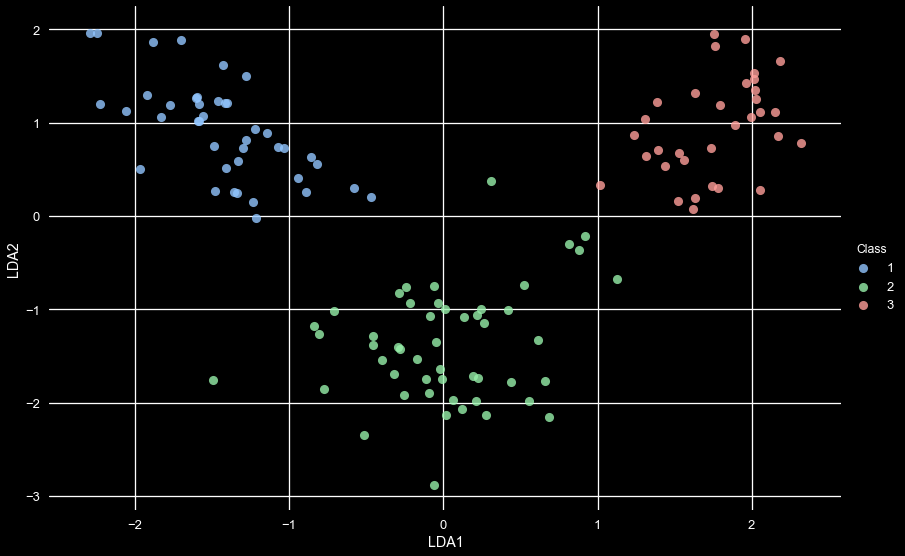

In [107]:
sns.lmplot(x='LDA1', y='LDA2', data=df, hue='Class', palette='pastel', fit_reg=False, 
           size=8, aspect=1.5)

### scikit-learn によるLDA

In [109]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)

In [113]:
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

<Figure size 432x288 with 0 Axes>

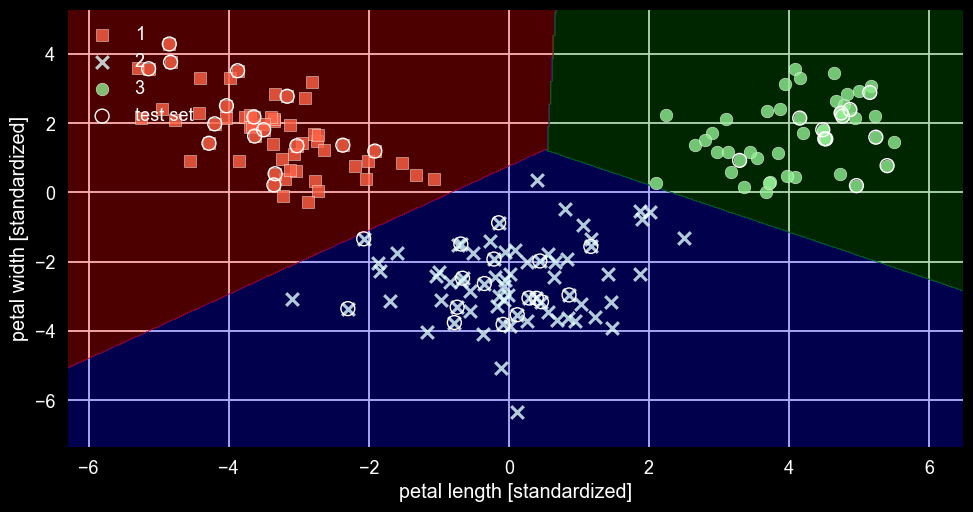

In [114]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', C=1.0, random_state=1)
svm.fit(X_train_lda, y_train)

X_combined_std = np.vstack((X_train_lda, X_test_lda))
y_combined = np.hstack((y_train, y_test))

%run myGraph.py
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=svm, test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()